In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
# import cleaned traffic data
df = pd.read_csv('../data/average_station_traffic.csv')
del df['Unnamed: 0']

# import Jayden entry data
df_ent = pd.read_csv('station_list_adj2.csv')
df_ent = df_ent.rename(columns={'colummn': 'STATION'})

In [5]:
# create short day/time for cleaning
df['Short_Day'] = df.apply(lambda x: x['Day'][:3], axis=1)
df['Short_Time'] = df.apply(
    lambda x: x['Time_Range'][:2] + ' to ' + x['Time_Range'][9:11], axis=1)
df['Short_Time_Range'] = df.apply(
    lambda x: x['Short_Day'] + "  " + x['Short_Time'], axis=1)

In [6]:
# merge the two dataframes
df_ent_traf = df.merge(df_ent, on='STATION')
df_ent_traf.dropna(inplace=True)
df_ent_traf.reset_index(inplace=True)

# create traffic/entry column - to be graphed
df_ent_traf['traf_by_ent'] = df_ent_traf.apply(
    lambda x: x['Total_Traffic'] / x['Number of Entrances'], axis=1)

In [7]:
# find top station for each bin
seriesname = df_ent_traf.groupby(['Day', 'Time_Range'])['traf_by_ent'].idxmax()
best_locs_df = df_ent_traf.iloc[seriesname].copy()

In [8]:
# categorize & sort data in custom order
day_list = ['Sunday', 'Monday', 'Tuesday',
            'Wednesday', 'Thursday', 'Friday', 'Saturday']
time_range_list = ['00:00 to 04:00', '04:00 to 08:00',
                   '08:00 to 12:00', '12:00 to 16:00',
                   '16:00 to 20:00', '20:00 to 00:00']

best_locs_df['Day'] = pd.Categorical(
    best_locs_df['Day'], categories=day_list, ordered=True)

best_locs_df['Time_Range'] = pd.Categorical(best_locs_df['Time_Range'],
                                            categories=time_range_list,
                                            ordered=True)

best_locs_df = best_locs_df.sort_values(['Day', 'Time_Range']).reset_index()
best_locs_df = best_locs_df.sort_index()

best_locs_df['Day_Range'] = best_locs_df.apply(
    lambda x: x['Day'] + " " + x['Time_Range'], axis=1)

In [9]:
# get best stations
best_stat_list = best_locs_df.groupby(['STATION']).count().reset_index()
best_stat_list = best_stat_list.STATION.tolist()

In [10]:
# get colors for each station name (has to be <6 unless you use a different palette)
current_palette = sns.color_palette('deep')[:len(best_stat_list)]

In [11]:
# create mapping for station/colors
d_st_clr = {}

for i in range(len(best_stat_list)):
    d_st_clr[best_stat_list[i]] = current_palette[i]

best_locs_df['color'] = best_locs_df["STATION"].map(d_st_clr)

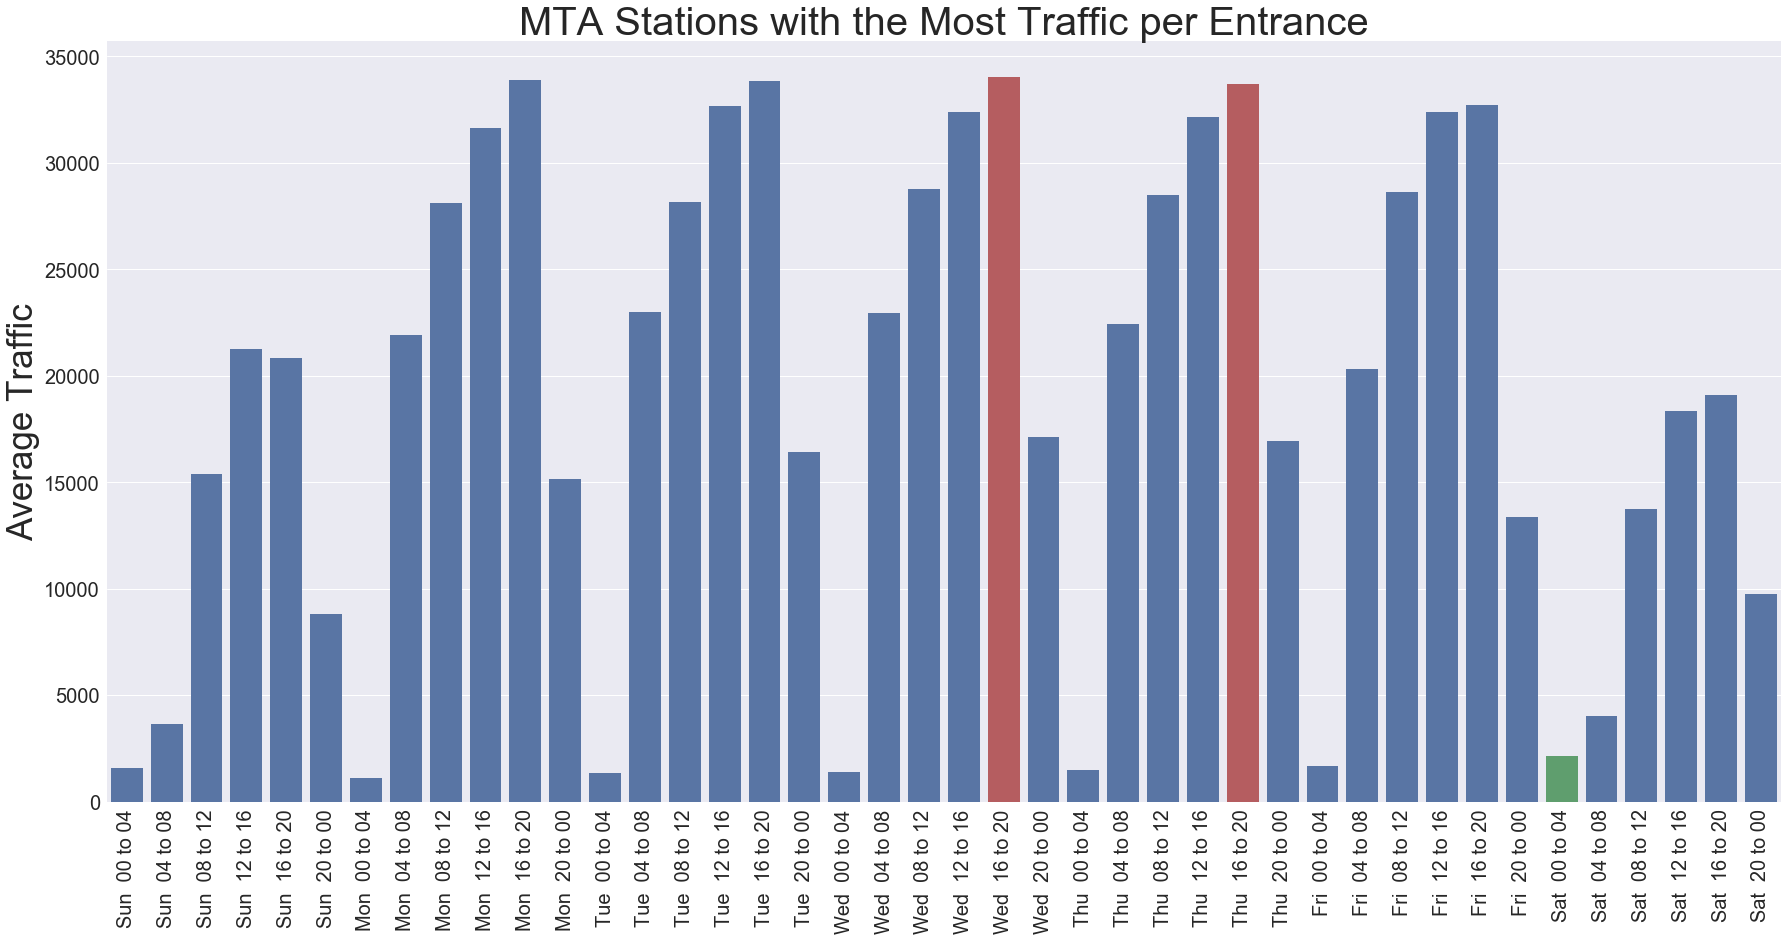

In [14]:
# plot it!
fig, ax = plt.subplots()
fig.set_size_inches(30, 14)
sns.set(font_scale=2)

fig = sns.barplot(x=best_locs_df['Short_Time_Range'],
                  y=best_locs_df['Total_Traffic'],
                  palette=best_locs_df['color'])

fig.set_title("MTA Stations with the Most Traffic per Entrance",
              fontsize=40)
ax.set_xticklabels(best_locs_df['Short_Time_Range'], rotation=90)

ax.set_xlabel('', fontsize=35)
ax.set_ylabel('Average Traffic', fontsize=35)